In [1]:
#@title Installation. { vertical-output: true }
#@markdown Run this notebook in Google Colab by following [this link](https://colab.research.google.com/github/google-research/perch/blob/main/embed_audio.ipynb).
#@markdown
#@markdown Run this cell to install the project dependencies.
%pip install git+https://github.com/google-research/perch.git

  Cloning https://github.com/google-research/perch.git to /tmp/pip-req-build-7zn8ih6c
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/perch.git /tmp/pip-req-build-7zn8ih6c
  Resolved https://github.com/google-research/perch.git to commit 5701b76a80b9e37975dc42c90cd97d8138d906e6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/google-research/perch-hoplite.git to /tmp/pip-install-m0gmazhw/perch-hoplite_f5df5a3e7d364ab4881613d9f5e536db
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/perch-hoplite.git /tmp/pip-install-m0gmazhw/perch-hoplite_f5df5a3e7d364ab4881613d9f5e536db
  Resolved https://github.com/google-research/perch-hoplite.git to commit 89510073db5052959ffd3589d2e773d9e7c3e5c8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata 

In [1]:
#@title Imports. { vertical-output: true }

from etils import epath
from ml_collections import config_dict
import numpy as np
import tensorflow as tf
import tqdm
from chirp.inference import colab_utils
colab_utils.initialize(use_tf_gpu=True, disable_warnings=True)

from chirp import audio_utils
from chirp.inference import embed_lib
from chirp.inference import tf_examples
from perch_hoplite.zoo import model_configs

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.6.2, so it will not be used.
  warnings.warn(


In [2]:
#@title Basic Configuration. { vertical-output: true }

#@markdown Define the model: perch or birdnet are most common for birds.
model_choice = 'humpback'  #@param['perch_8', 'humpback', 'multispecies_whale', 'surfperch', 'birdnet_V2.3']
#@markdown Set the base directory for the project.
working_dir = '/tmp/agile'  #@param

# Set the embedding and labeled data directories.
embeddings_path = epath.Path(working_dir) / 'embeddings'
labeled_data_path = epath.Path(working_dir) / 'labeled'
embeddings_glob = embeddings_path / 'embeddings-*'

# OPTIONAL: Set up separation model.
separation_model_key = 'separator_model_tf'  #@param
separation_model_path = ''  #@param

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
#@title Create a new folder in Drive (if it doesn't already exist) within your Google drive.
base_dir = '/content/drive/MyDrive/'
#@ markdown Name of your new folder in Drive
new_folder_name = 'whale_denoising' #@param

drive_output_directory = base_dir + new_folder_name

try:
  if not os.path.exists(drive_output_directory):
    os.makedirs(drive_output_directory, exist_ok=True)
    print(f'Directory {drive_output_directory} created successfully.')
  else:
    print(f'Directory {drive_output_directory} already exists.')
except OSError as e:
    print("Error:", e)

Directory /content/drive/MyDrive/whale_denoising already exists.


In [5]:
#@title Embedding Configuration. { vertical-output: true }

config = config_dict.ConfigDict()
config.embed_fn_config = config_dict.ConfigDict()
config.embed_fn_config.model_config = config_dict.ConfigDict()

#@markdown IMPORTANT: Select the target audio files.
#@markdown source_file_patterns should contain a list of globs of audio files, like:
#@markdown ['/home/me/*.wav', '/home/me/other/*.flac']
#config.source_file_patterns = ['gs://chirp-public-bucket/soundscapes/powdermill/Recording*/*.wav']  #@param
config.source_file_patterns = ['/content/drive/MyDrive/whale_denoising/noisy/*.wav', '/content/drive/MyDrive/whale_denoising/clean/*.wav']  #@param
config.output_dir = embeddings_path.as_posix()

preset_info = model_configs.get_preset_model_config(model_choice)
config.embed_fn_config.model_key = preset_info.model_key
config.embed_fn_config.model_config = preset_info.model_config

# Only write embeddings to reduce size.
config.embed_fn_config.write_embeddings = True
config.embed_fn_config.write_logits = False
config.embed_fn_config.write_separated_audio = False
config.embed_fn_config.write_raw_audio = False

#@markdown File sharding automatically splits audio files into one-minute chunks
#@markdown for embedding. This limits both system and GPU memory usage,
#@markdown especially useful when working with long files (>1 hour).
use_file_sharding = False  #@param {type:'boolean'}
if use_file_sharding:
  config.shard_len_s = 60.0

# Number of parent directories to include in the filename.
config.embed_fn_config.file_id_depth = 1

In [6]:
#@title Set up. { vertical-output: true }

# Set up the embedding function, including loading models.
embed_fn = embed_lib.EmbedFn(**config.embed_fn_config)
print('\n\nLoading model(s)...')
embed_fn.setup()

# Create output directory and write the configuration.
output_dir = epath.Path(config.output_dir)
output_dir.mkdir(exist_ok=True, parents=True)
embed_lib.maybe_write_config(config, output_dir)

# Create SourceInfos.
source_infos = embed_lib.create_source_infos(
    config.source_file_patterns,
    num_shards_per_file=config.get('num_shards_per_file', -1),
    shard_len_s=config.get('shard_len_s', -1))
print(f'Found {len(source_infos)} source infos.')

print('\n\nTest-run of model...')
window_size_s = config.embed_fn_config.model_config.window_size_s
sr = config.embed_fn_config.model_config.sample_rate
z = np.zeros([int(sr * window_size_s)], dtype=np.float32)
embed_fn.embedding_model.embed(z)
print('Setup complete!')



Loading model(s)...
Found 1473 source infos.


Test-run of model...
Setup complete!


# Extract the model

In [7]:
embedding_model = embed_fn.embedding_model

In [ ]:
#@title Run embedding. { vertical-output: true }

# Uses multiple threads to load audio before embedding.
# This tends to be faster, but can fail if any audio files are corrupt.

embed_fn.min_audio_s = 1.0
record_file = (output_dir / 'embeddings.tfrecord').as_posix()
succ, fail = 0, 0

existing_embedding_ids = embed_lib.get_existing_source_ids(
    output_dir, 'embeddings-*')

new_source_infos = embed_lib.get_new_source_infos(
    source_infos, existing_embedding_ids, config.embed_fn_config.file_id_depth)

print(f'Found {len(existing_embedding_ids)} existing embedding ids. \n'
      f'Processing {len(new_source_infos)} new source infos. ')

try:
  audio_loader = lambda fp, offset: audio_utils.load_audio_window(
      fp, offset, sample_rate=config.embed_fn_config.model_config.sample_rate,
      window_size_s=config.get('shard_len_s', -1.0))
  audio_iterator = audio_utils.multi_load_audio_window(
      filepaths=[s.filepath for s in new_source_infos],
      offsets=[s.shard_num * s.shard_len_s for s in new_source_infos],
      audio_loader=audio_loader,
  )
  with tf_examples.EmbeddingsTFRecordMultiWriter(
      output_dir=output_dir, num_files=config.get('tf_record_shards', 1)) as file_writer:
    for source_info, audio in tqdm.tqdm(
        zip(new_source_infos, audio_iterator), total=len(new_source_infos)):
      if not embed_fn.validate_audio(source_info, audio):
        continue
      file_id = source_info.file_id(config.embed_fn_config.file_id_depth)
      offset_s = source_info.shard_num * source_info.shard_len_s
      example = embed_fn.audio_to_example(file_id, offset_s, audio)
      if example is None:
        fail += 1
        continue
      file_writer.write(example.SerializeToString())
      succ += 1
    file_writer.flush()
finally:
  del(audio_iterator)
print(f'\n\nSuccessfully processed {succ} source_infos, failed {fail} times.')

fns = [fn for fn in output_dir.glob('embeddings-*')]
ds = tf.data.TFRecordDataset(fns)
parser = tf_examples.get_example_parser()
ds = ds.map(parser)
for ex in ds.as_numpy_iterator():
  print(ex['filename'])
  print(ex['embedding'].shape, flush=True)
  break

Found 0 existing embedding ids. 
Processing 1473 new source infos. 


100%|██████████| 1473/1473 [07:24<00:00,  3.32it/s]



Successfully processed 1473 source_infos, failed 0 times.
b'noisy/whale_1_10k.wav'
(1, 1, 2048)


# This is wrong

In [16]:
import json
import torch
from chirp.models import build_model
from chirp.inference import embed_lib

# Load config from JSON
with open("/tmp/agile/embeddings/config.json", "r") as f:
    full_config = json.load(f)

model_config_dict = full_config["embed_fn_config"]["model_config"]

# Build model
embedding_model = build_model.build_model(model_config_dict)

# Load weights from TensorFlow Hub
model_url = model_config_dict["model_url"]
embedding_model = embed_lib.load_tfhub_model(model_url, embedding_model)
embedding_model.eval()

# Wrap in embed_fn
embed_fn = embed_lib.EmbedFn(embedding_model, frontend=True)

ImportError: cannot import name 'build_model' from 'chirp.models' (unknown location)

In [27]:
print(type(embedding_model))
print(dir(embedding_model))


<class 'perch_hoplite.zoo.models_tf.GoogleWhaleModel'>
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'batch_embed', 'class_list', 'embed', 'frame_audio', 'from_config', 'hop_size_s', 'load_humpback_model', 'model', 'model_url', 'normalize_audio', 'peak_norm', 'sample_rate', 'window_size_s']


# Train Denoiser

In [11]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

# Simple 1D convolutional denoiser
class Denoiser1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=15, padding=7)
        )

    def forward(self, x):
        return self.net(x)

denoiser = Denoiser1D().cuda()
optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()



Define data loader

In [54]:
class WhaleDenoisingDataset(Dataset):
    def __init__(self, clean_paths, noise_paths, snr_db_range=(10, 25)):
        self.clean_paths = clean_paths
        self.noise_paths = noise_paths
        self.snr_db_range = snr_db_range

    def __len__(self):
        return len(self.clean_paths)

    def __getitem__(self, idx):
        clean_path = self.clean_paths[idx]
        noise_path = random.choice(self.noise_paths)

        clean, _ = torchaudio.load(clean_path)
        noise, _ = torchaudio.load(noise_path)

        clean = clean[0]  # (T,)
        noise = noise[0]

        # Ensure same length (crop or pad)
        target_len = 39124
        if len(clean) < target_len:
            clean = torch.nn.functional.pad(clean, (0, target_len - len(clean)))
        else:
            clean = clean[:target_len]

        if len(noise) < target_len:
            noise = torch.nn.functional.pad(noise, (0, target_len - len(noise)))
        else:
            start = random.randint(0, len(noise) - target_len)
            noise = noise[start:start+target_len]

        # Mix at random SNR
        snr_db = random.uniform(*self.snr_db_range)
        alpha = 10 ** (-snr_db / 20)
        noisy = clean + alpha * noise

        return noisy, clean



noisy_paths = sorted(glob.glob('/content/drive/MyDrive/whale_denoising/noisy/*.wav'))
clean_paths = sorted(glob.glob('/content/drive/MyDrive/whale_denoising/clean/*.wav'))
#noisy_dataset = NoisyWhaleDataset(noisy_paths)
#train_loader = DataLoader(noisy_dataset, batch_size=16, shuffle=True)
train_dataset = WhaleDenoisingDataset(clean_paths, noisy_paths)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [55]:
noisy, clean = train_dataset[0]
ipd.display(ipd.Audio(clean.numpy(), rate=10000))  # Clean whale
ipd.display(ipd.Audio(noisy.numpy(), rate=10000))  # Clean + real-world noise


In [14]:
print(dir(embed_fn))

['BundleContextParam', 'BundleFinalizerParam', 'DoFnProcessParams', 'DynamicTimerTagParam', 'ElementParam', 'KeyParam', 'PaneInfoParam', 'RestrictionParam', 'SetupContextParam', 'SideInputParam', 'StateParam', 'TimerParam', 'TimestampParam', 'WatermarkEstimatorParam', 'WindowParam', 'WindowedValueParam', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_can_yield_batches', '_get_display_data_namespace', '_get_element_type_from_return_annotation', '_get_input_batch_type_normalized', '_get_or_create_type_hints', '_get_output_batch_type_normalized', '_known_urns', '_log_exception', '_process_argspec_fn', '_process_batch_defined', '_process_batch_yields_elements', 

# Training Loop

In [56]:
for epoch in range(50):
    denoiser.train()
    total_loss = 0
    total_score = 0
    total_batches = 0

    for noisy, clean in tqdm(train_loader):
        noisy = noisy.unsqueeze(1).cuda()   # (B, 1, T)
        clean = clean.unsqueeze(1).cuda()   # (B, 1, T)
        denoised = denoiser(noisy)

        # Reconstruction loss (supervised denoising)
        recon_loss = mse_loss(denoised, clean)

        # Convert to numpy for whale score monitoring
        def to_numpy_for_tf(x):
            x = x.detach().squeeze(1).cpu().numpy()
            x = x[..., np.newaxis].astype(np.float32)
            target_len = 39124
            return x[:, :target_len, :] if x.shape[1] > target_len else np.pad(
                x, ((0, 0), (0, target_len - x.shape[1]), (0, 0))
            )

        denoised_np = to_numpy_for_tf(denoised)

        # Whale score from TF model (not used in loss, just for monitoring)
        whale_scores = embedding_model.model(denoised_np, False, None).numpy()
        mean_score = whale_scores.mean()

        # Backprop only on MSE loss
        optimizer.zero_grad()
        recon_loss.backward()
        optimizer.step()

        total_loss += recon_loss.item()
        total_score += mean_score
        total_batches += 1

    print(f"Epoch {epoch+1}: recon_loss = {total_loss / total_batches:.4f} | whale score = {total_score / total_batches:.4f}")



100%|██████████| 35/35 [00:20<00:00,  1.68it/s]


Epoch 1: recon_loss = 0.0004 | whale score = 2.8020


100%|██████████| 35/35 [00:17<00:00,  2.03it/s]


Epoch 2: recon_loss = 0.0003 | whale score = 3.0254


100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


Epoch 3: recon_loss = 0.0003 | whale score = 3.4959


100%|██████████| 35/35 [00:17<00:00,  2.03it/s]


Epoch 4: recon_loss = 0.0003 | whale score = 3.8416


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 5: recon_loss = 0.0003 | whale score = 3.7932


100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 6: recon_loss = 0.0003 | whale score = 3.9787


100%|██████████| 35/35 [00:17<00:00,  1.96it/s]


Epoch 7: recon_loss = 0.0003 | whale score = 3.7818


100%|██████████| 35/35 [00:18<00:00,  1.94it/s]


Epoch 8: recon_loss = 0.0003 | whale score = 3.8044


100%|██████████| 35/35 [00:17<00:00,  2.03it/s]


Epoch 9: recon_loss = 0.0002 | whale score = 3.8459


100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


Epoch 10: recon_loss = 0.0003 | whale score = 3.8074


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 11: recon_loss = 0.0002 | whale score = 3.8678


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 12: recon_loss = 0.0003 | whale score = 3.8409


100%|██████████| 35/35 [00:17<00:00,  1.96it/s]


Epoch 13: recon_loss = 0.0003 | whale score = 3.8500


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 14: recon_loss = 0.0002 | whale score = 3.8744


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 15: recon_loss = 0.0003 | whale score = 3.8459


100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


Epoch 16: recon_loss = 0.0003 | whale score = 3.8497


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch 17: recon_loss = 0.0003 | whale score = 3.8985


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch 18: recon_loss = 0.0003 | whale score = 3.8835


100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


Epoch 19: recon_loss = 0.0003 | whale score = 3.8753


100%|██████████| 35/35 [00:17<00:00,  1.95it/s]


Epoch 20: recon_loss = 0.0003 | whale score = 3.8911


100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 21: recon_loss = 0.0003 | whale score = 3.9462


100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


Epoch 22: recon_loss = 0.0003 | whale score = 3.9642


100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


Epoch 23: recon_loss = 0.0003 | whale score = 3.8943


100%|██████████| 35/35 [00:17<00:00,  2.03it/s]


Epoch 24: recon_loss = 0.0003 | whale score = 3.9254


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch 25: recon_loss = 0.0002 | whale score = 3.9143


100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


Epoch 26: recon_loss = 0.0002 | whale score = 4.0186


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 27: recon_loss = 0.0003 | whale score = 4.0168


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 28: recon_loss = 0.0002 | whale score = 4.0101


100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


Epoch 29: recon_loss = 0.0002 | whale score = 3.9199


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 30: recon_loss = 0.0003 | whale score = 3.9880


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 31: recon_loss = 0.0003 | whale score = 4.0187


100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 32: recon_loss = 0.0003 | whale score = 4.0594


100%|██████████| 35/35 [00:17<00:00,  2.01it/s]


Epoch 33: recon_loss = 0.0003 | whale score = 4.1319


100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch 34: recon_loss = 0.0003 | whale score = 4.0302


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 35: recon_loss = 0.0003 | whale score = 4.1312


100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


Epoch 36: recon_loss = 0.0003 | whale score = 3.9831


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 37: recon_loss = 0.0003 | whale score = 4.0201


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 38: recon_loss = 0.0003 | whale score = 4.1000


100%|██████████| 35/35 [00:17<00:00,  1.99it/s]


Epoch 39: recon_loss = 0.0003 | whale score = 4.0774


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch 40: recon_loss = 0.0003 | whale score = 4.1642


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 41: recon_loss = 0.0003 | whale score = 4.0158


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch 42: recon_loss = 0.0002 | whale score = 4.0951


100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


Epoch 43: recon_loss = 0.0003 | whale score = 4.0402


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 44: recon_loss = 0.0002 | whale score = 4.1309


100%|██████████| 35/35 [00:16<00:00,  2.07it/s]


Epoch 45: recon_loss = 0.0002 | whale score = 4.0878


100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


Epoch 46: recon_loss = 0.0003 | whale score = 4.0959


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch 47: recon_loss = 0.0003 | whale score = 4.1187


100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch 48: recon_loss = 0.0003 | whale score = 4.1703


100%|██████████| 35/35 [00:18<00:00,  1.94it/s]


Epoch 49: recon_loss = 0.0002 | whale score = 4.0600


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]

Epoch 50: recon_loss = 0.0002 | whale score = 4.0375


# Save trained model to disk

In [59]:
torch.save(denoiser.state_dict(), "/content/drive/MyDrive/whale_denoising/whale_denoiser.pt")


In [64]:
import IPython.display as ipd
import torchaudio

# === Configurable number of passes ===
NUM_PASSES = 5  # ← change this to however many iterations you want

# === Load real-world noisy sample ===
noisy_path = noisy_paths[0]  # or any index
waveform, sr = torchaudio.load(noisy_path)
waveform = waveform[0]  # shape (T,)

# === Prepare input ===
current = waveform.unsqueeze(0).unsqueeze(0).cuda()  # (1, 1, T)

# === Apply denoiser iteratively ===
denoiser.eval()
outputs = [waveform.cpu().numpy()]  # store original as first output

with torch.no_grad():
    for _ in range(NUM_PASSES):
        current = denoiser(current)
        outputs.append(current.squeeze().cpu().numpy())

# === Playback original and final ===
print("🔊 Original Noisy Input:")
ipd.display(ipd.Audio(outputs[0], rate=sr))

print(f"🔊 After {NUM_PASSES} Passes:")
ipd.display(ipd.Audio(outputs[-1], rate=sr))


🔊 Original Noisy Input:


🔊 After 5 Passes:


# Listen to denoised output

In [58]:
denoiser.eval()
with torch.no_grad():
    test_waveform, _ = torchaudio.load(noisy_paths[0])
    test_tensor = test_waveform.unsqueeze(0).cuda()  # shape: (1, 1, T)
    denoised_tensor = denoiser(test_tensor).squeeze().cpu()

import IPython.display as ipd
print("🔊 Noisy input:")
ipd.display(ipd.Audio(test_waveform.numpy(), rate=10000))

print("🔊 Denoised output:")
ipd.display(ipd.Audio(denoised_tensor.numpy(), rate=10000))

🔊 Noisy input:


🔊 Denoised output:


In [50]:
import IPython.display as ipd
import torchaudio

# Pick a clean audio file from your training set
waveform, sr = torchaudio.load(clean_paths[0])  # or any other index
waveform = waveform[0]  # shape (T,)

# Add synthetic noise to simulate what was done during training
import torch
import numpy as np

noise = torch.randn_like(waveform)
snr_db = 10  # adjust this for testing
alpha = 10 ** (-snr_db / 20)
noisy = waveform + alpha * noise

# Run the denoiser
denoiser.eval()
with torch.no_grad():
    input_tensor = noisy.unsqueeze(0).unsqueeze(0).cuda()  # (1, 1, T)
    denoised_tensor = denoiser(input_tensor).squeeze().cpu()

# 🔊 Listen
print("🔊 Noisy input:")
ipd.display(ipd.Audio(noisy.numpy(), rate=sr))

print("🔊 Denoised output:")
ipd.display(ipd.Audio(denoised_tensor.numpy(), rate=sr))

print("🔊 Original clean:")
ipd.display(ipd.Audio(waveform.numpy(), rate=sr))



🔊 Noisy input:


🔊 Denoised output:


🔊 Original clean:


# Check that model output is a good measure of whaliness

Processing clean files...


100%|██████████| 550/550 [00:30<00:00, 18.08it/s]


Processing noisy files...


100%|██████████| 923/923 [08:18<00:00,  1.85it/s]



✅ Clean mean score: 4.1279
✅ Noisy mean score: -0.8687


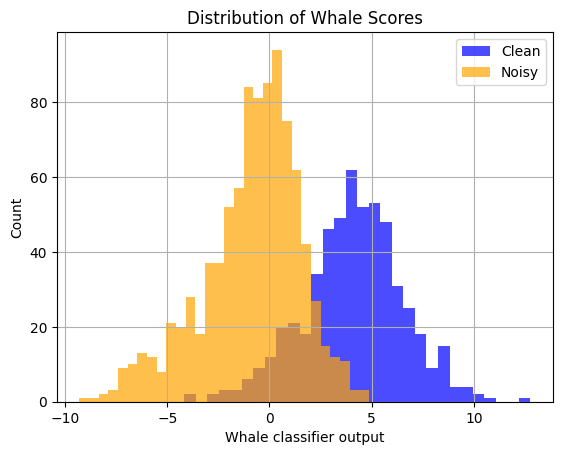

In [30]:
import numpy as np
import torchaudio
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_and_prepare(path, target_len=39124):
    waveform, sr = torchaudio.load(path)
    waveform = waveform.squeeze(0).numpy()
    waveform = waveform[:target_len] if len(waveform) > target_len else np.pad(waveform, (0, target_len - len(waveform)))
    waveform = waveform.astype(np.float32)[np.newaxis, :, np.newaxis]  # shape (1, T, 1)
    return waveform

# Run model on clean and noisy sets
clean_scores = []
print("Processing clean files...")
for path in tqdm(clean_paths):
    audio = load_and_prepare(path)
    score = embedding_model.model(audio, False, None).numpy().item()
    clean_scores.append(score)

noisy_scores = []
print("Processing noisy files...")
for path in tqdm(noisy_paths):
    audio = load_and_prepare(path)
    score = embedding_model.model(audio, False, None).numpy().item()
    noisy_scores.append(score)

# Print means
print(f"\n✅ Clean mean score: {np.mean(clean_scores):.4f}")
print(f"✅ Noisy mean score: {np.mean(noisy_scores):.4f}")

# Optional: histogram plot
plt.hist(clean_scores, bins=30, alpha=0.7, label='Clean', color='blue')
plt.hist(noisy_scores, bins=30, alpha=0.7, label='Noisy', color='orange')
plt.xlabel("Whale classifier output")
plt.ylabel("Count")
plt.title("Distribution of Whale Scores")
plt.legend()
plt.grid(True)
plt.show()
